# In this Jupiter notebook, I prepared the basic methods for implementing the algorithms and models that we used. First of all, this is LSTM, as in the beginning we tried to model on ARCH, ARIMA and similar models.

---



In [35]:
pip install arch

     |████████████████████████████████| 808kB 5.7MB/s 


In [36]:
# Import the libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from random import gauss
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [37]:
df = pd.read_pickle('dataframe.pkl.zip')

In [38]:
df_comp = df.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.set_index("date", inplace=True)


In [39]:
def check_data():
    plt.figure(figsize=(28, 12))

    plt.subplot(2, 2, 1)
    plt.plot(sdf.index, sdf.price)
    plt.title("APPLE PRICE DATA", size = 20)

    plt.subplot(2, 2, 2)
    plt.plot(sdf.index, sdf.open)
    plt.title("APPLE OPEN DATA", size = 20)

    plt.subplot(2, 2, 3)
    plt.plot(sdf.index, sdf.low)
    plt.title("APPLE LOW DATA", size = 20)

    plt.subplot(2, 2, 4)
    plt.plot(sdf.index, sdf.high)
    plt.title("APPLE HIGH DATA", size = 20)
    
    plt.show()

**Normalize data**

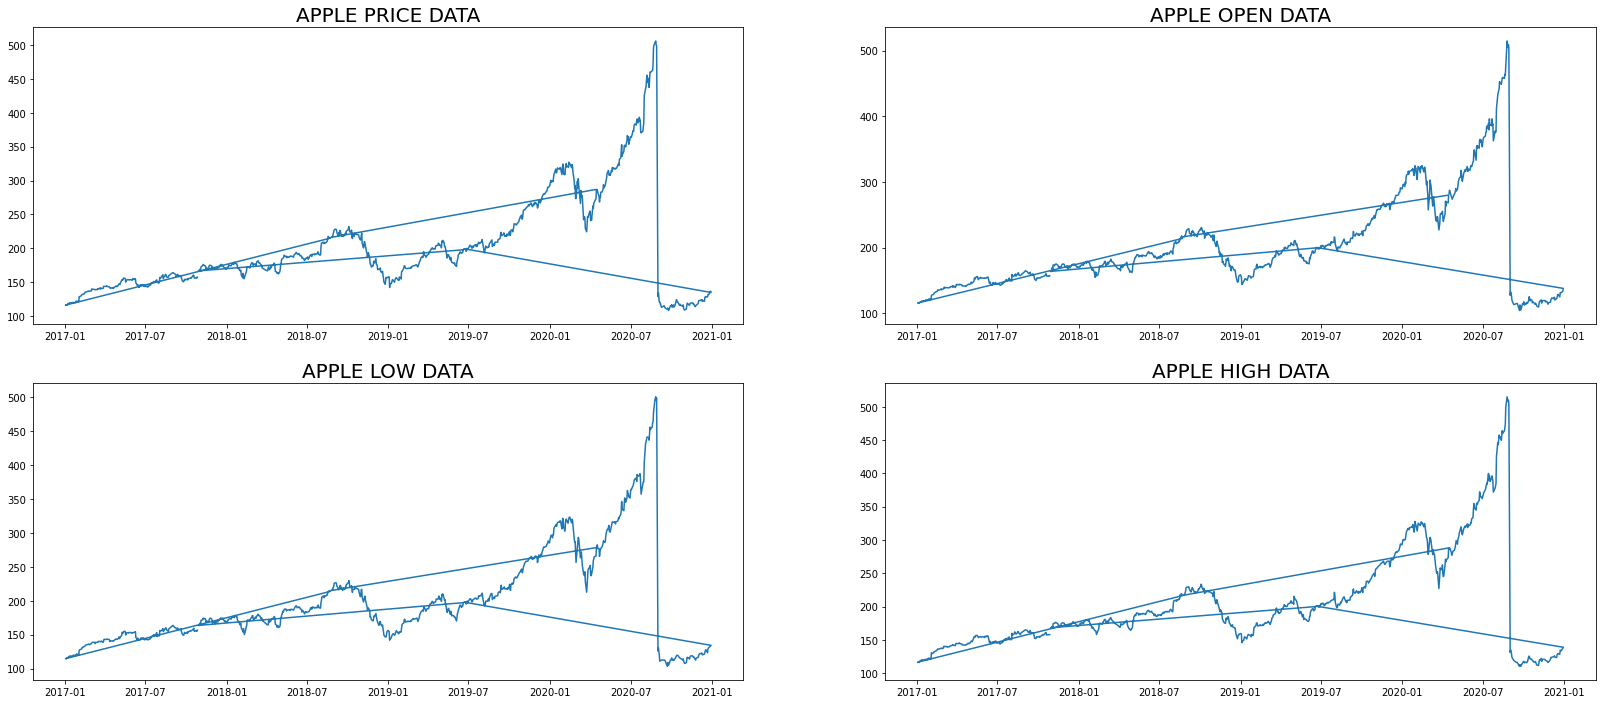

In [40]:
sdf = df_comp.copy()
check_data()

**We know that Apple announced a 4:1 stock split on July 30, 2020.**

At this stage of our development, we bring the dataframe back to normal manually.

*Fill in the missing data in the dataset with the average value of the nearest points:*

In [41]:
sdf = df_comp.copy()

sdf = sdf.sort_index()
sdf = sdf.asfreq('d')
sdf.price = sdf.price.fillna(method="ffill")
sdf.change = sdf.change.fillna(method="ffill")
sdf.open = sdf.open.fillna(method="ffill")
sdf.high = sdf.high.fillna(method="ffill")
sdf.low = sdf.low.fillna(method="ffill")

In [42]:
for i in range(len(sdf)-123):
    sdf.price[i] = sdf.price[i] / 4
    sdf.high[i] = sdf.high[i] / 4
    sdf.low[i] = sdf.low[i] / 4
    sdf.open[i] = sdf.open[i] / 4

sdf.price[-123] = (sdf.price[-124] + sdf.price[-121]) / 2
sdf.price[-122] = (sdf.price[-123] + sdf.price[-121]) / 2
sdf.low[-123] = (sdf.low[-124] + sdf.low[-121]) / 2
sdf.low[-122] = (sdf.low[-123] + sdf.low[-121]) / 2
sdf.high[-123] = (sdf.high[-124] + sdf.high[-121]) / 2
sdf.high[-122] = (sdf.high[-123] + sdf.high[-121]) / 2
sdf.open[-123] = (sdf.open[-124] + sdf.open[-121]) / 2
sdf.open[-122] = (sdf.open[-123] + sdf.open[-121]) / 2
sdf = sdf.iloc[1:]
sdf = sdf[['open', 'price', 'low', 'high']].copy()

*Now we need to check the result and if the data is normalized, we can proceed to the forecasts.*

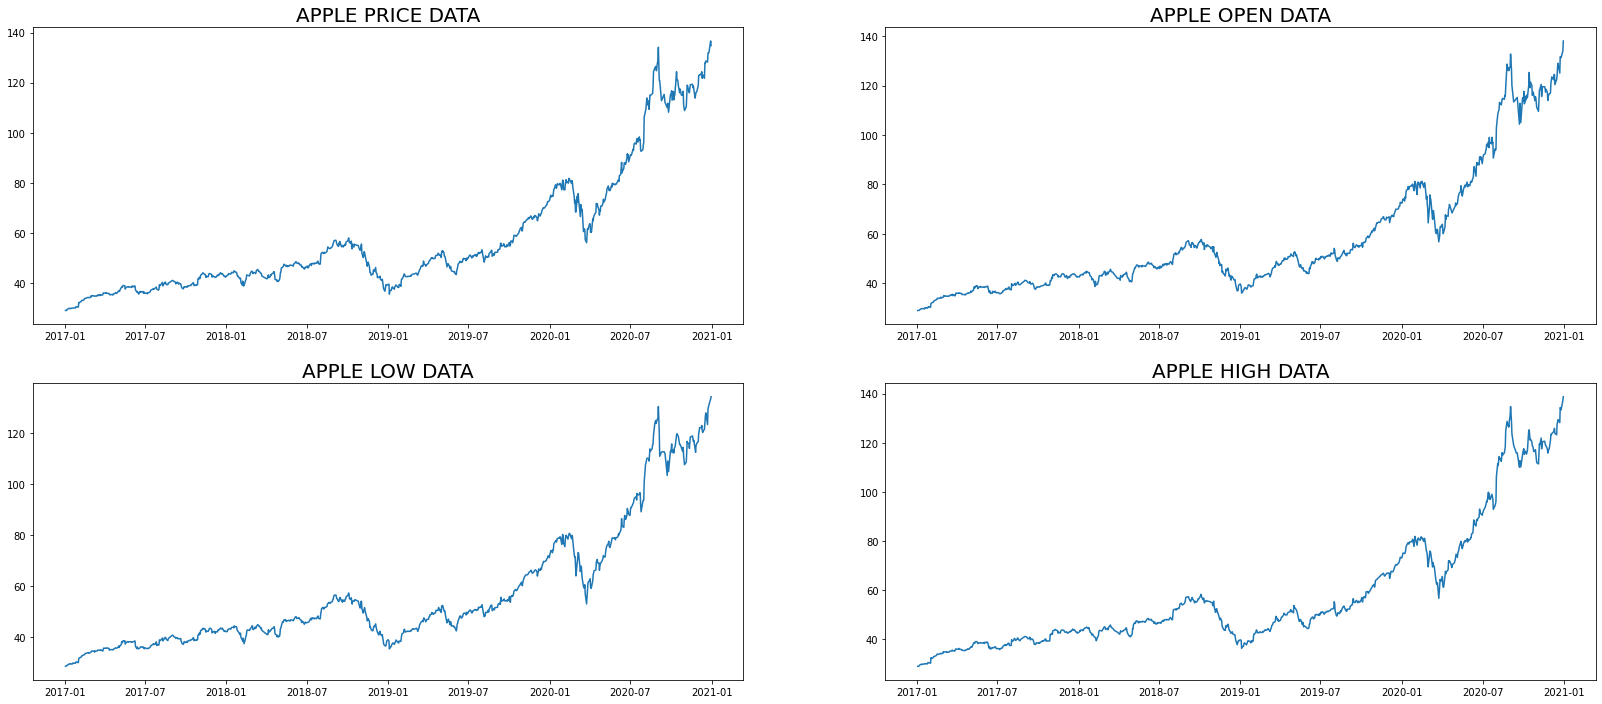

In [43]:
check_data()

We'll predict **APPLE PRICE DATA**

# **LSTM model:** 

In [44]:
class Prepare:
    def fit(self, data):
        data = np.log(data.values.copy())
        self.last_val = data[-1].copy()
        data = data[1:] - data[:-1]
        self.mean = data.mean()
        self.std = data.std()
        return (data - self.mean) / self.std
    def transform(self, data, init_val=None):
        if init_val is None:
            init_val = self.last_val
        data = np.log(data.values.copy())
        data = data - np.array([init_val, *data[:-1]])
        return (data - self.mean) / self.std

    def reverse(self, data, init_val=None):
        if init_val is None:
            init_val = self.last_val
        data = data * self.std + self.mean
        data = np.cumsum(np.array([init_val, *data]))[1:]
        return np.exp(data)
    
class PrepareDf:
    def fit(self, df):
        self.cols = df.columns
        self.p = {}
        r = []
        for col in self.cols:
            self.p[col] = Prepare()
            r.append(self.p[col].fit(df[col]))
        return np.array(r).T
    def transform(self, df):
        r = []
        for col in self.cols:
            r.append(self.p[col].transform(df[col]))
        return np.array(r).T
    def reverse(self, data):
        r = {}
        for col, col_data in zip(self.cols, data.T):
            r[col] = self.p[col].reverse(col_data)
        return pd.DataFrame(r)
    
def gen_recurrent_data(data, size):
    out = []
    for i in range(len(data) - size):
        out.append(data[i:i + size])
    return np.array(out)

In [45]:
p = Prepare()
a = p.fit(sdf['open'])
b = p.transform(sdf['open'][1:], np.log(sdf['open'][0]))
c = p.reverse(b, np.log(sdf['open'][0]))
a.shape, b.shape, c.shape

((1457,), (1457,), (1457,))

In [46]:
p = Prepare()
a = p.fit(sdf['open'][:1000])
b = p.transform(sdf['open'][1000:])
c = p.reverse(b)

In [47]:
p = PrepareDf()
a = p.fit(sdf)
p.reverse(a)

,open,price,low,high
0,138.050000,134.870000,134.360000,138.780000
1,138.109607,134.719048,135.519083,138.994737
2,138.193057,135.404139,135.589331,139.412282
3,139.218299,136.913661,136.362053,140.963163
4,139.683234,137.331682,136.935741,141.468194
...,...,...,...,...
1452,629.391170,618.439621,616.796229,641.492148
1453,632.574188,623.920348,619.629543,646.120932
1454,635.757206,629.401074,622.462858,650.749715
1455,638.940225,634.881801,625.296173,655.378499


In [48]:
SIZE = 14
SPLIT = 950
SPLIT = 1010
p = Prepare()
data_train1 = p.fit(sdf['price'][:SPLIT])
target_train = data_train1[SIZE + 1:].copy()
data_train2 = data_train1[:-1].copy()
data_train3 = gen_recurrent_data(data_train2, SIZE)
data_train3 = data_train3.reshape((*data_train3.shape, 1))


data_test1 = p.transform(sdf['price'][SPLIT:])
target_test = data_test1[1:].copy()
data_test2 = data_test1[:-1].copy()
data_test3 = gen_recurrent_data(np.hstack([data_train2[-14:], data_test2]), SIZE)
data_test3 = data_test3.reshape((*data_test3.shape, 1))

In [49]:
def make_model():
    # reg = tf.keras.regularizers.L2(l2=0.0000001)
    reg = None
    inp = layers.Input(shape=(None, 1))
    x = inp
    x = layers.LSTM(32, kernel_regularizer=reg)(x)   
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1, kernel_regularizer=reg)(x)
    model = Model(inputs=inp, outputs=x, name='LSTM')
    model.compile(loss='MeanSquaredError', optimizer='adam', metrics=['MSE', 'MAE'])
    model.summary()
    return model

model = make_model()
h = model.fit(data_train3, target_train, validation_data=(data_test3, target_test), epochs=28, verbose=1)

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,513
Trainable params: 4,449
Non-trainable params: 64
_________________________________________________________________
Epoch 1/28
32/32 [==============================] - 3s 26ms/step - loss: 1.6938 - MSE: 1.6938 - MAE: 0.9286 - val_loss: 1.9825 - val_MSE: 1.9825 - val_MAE: 0.9134
Epoch 2/28
32/32 [==============================] - 0s 9ms/step - loss: 1.2711 - MSE: 1.2711 -

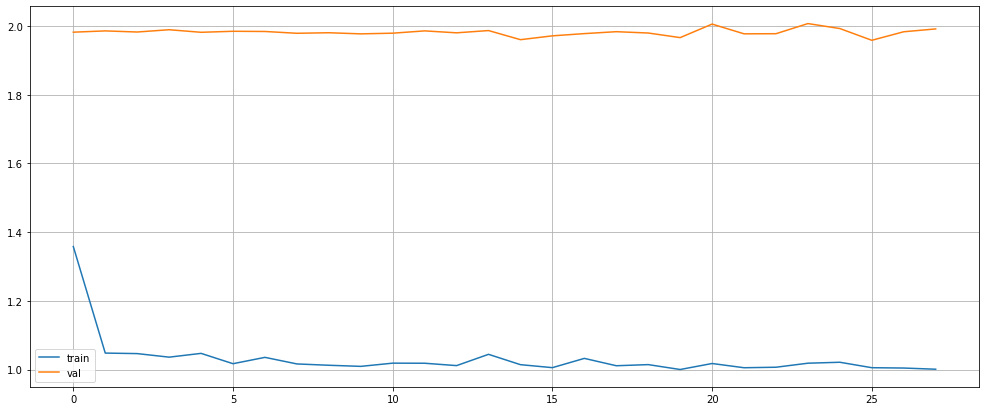

In [50]:
plt.figure(figsize=(17, 7), facecolor='w')
plt.plot(h.history['MSE'], label='train')
plt.plot(h.history['val_MSE'], label='val')
# plt.plot(h.history['val_MAE'], label='val')
plt.grid()
plt.legend()

In [51]:
predict1 = model.predict(data_test3)[:, 0]
predict2 = []
data = list(data_train3[-1, :, 0])
while len(predict2) < len(predict1):
    data2 = np.array(data).reshape((1, -1, 1))
    predict2.append(model.predict(data_test3)[0, 0])
    data = data[1:] + predict2[-1:]
predict2 = np.array(predict2)

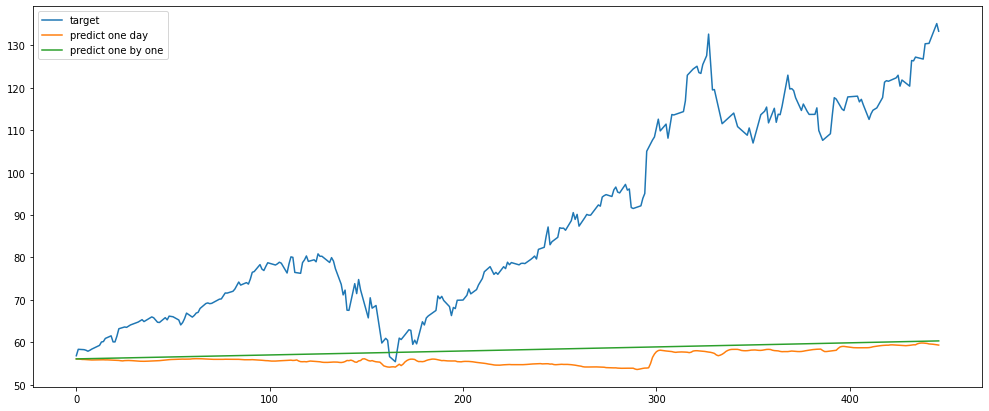

In [52]:
plt.figure(figsize=(17, 7), facecolor='w')
plt.plot(p.reverse(target_test), label='target')
plt.plot(p.reverse(predict1), label='predict one day')
plt.plot(p.reverse(predict2), label='predict one by one')
plt.legend()
# plt.ylim([-2, 2])

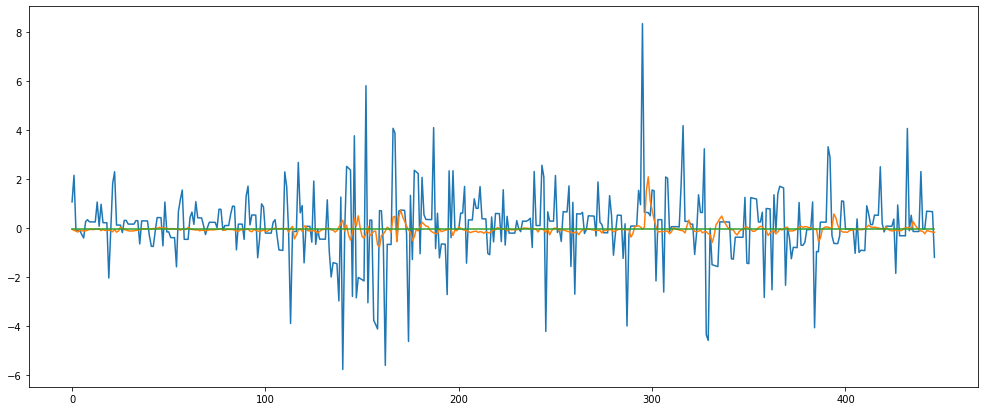

In [53]:
plt.figure(figsize=(17, 7), facecolor='w')
plt.plot(target_test, label='target')
plt.plot(predict1, label='predict one day')
plt.plot(predict2, label='predict one by one')

# **ARCH(GARCH) family:**

In [54]:
# create dataset
n = 1000
omega = 0.5

alpha_1 = 0.1
alpha_2 = 0.2

beta_1 = 0.3
beta_2 = 0.4

test_size = int(n*0.1)

series = [gauss(0,1), gauss(0,1)]
vols = [1, 1]

for _ in range(n):
    new_vol = np.sqrt(omega + alpha_1*series[-1]**2 + alpha_2*series[-2]**2 + beta_1*vols[-1]**2 + beta_2*vols[-2]**2)
    new_val = gauss(0,1) * new_vol
    
    vols.append(new_vol)
    series.append(new_val)

Text(0.5, 1.0, 'Simulated GARCH(2,2) Data')

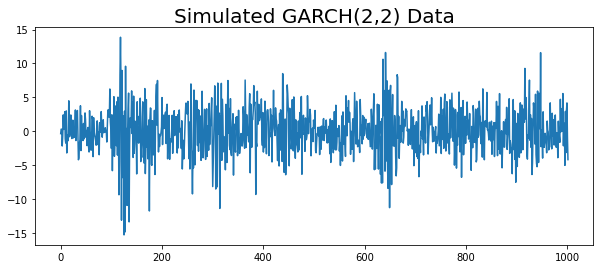

In [55]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title('Simulated GARCH(2,2) Data', fontsize=20)

Text(0.5, 1.0, 'Data Volatility')

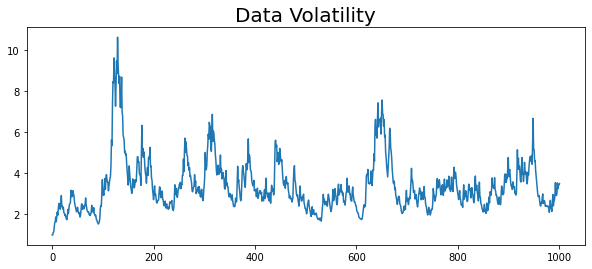

In [56]:
plt.figure(figsize=(10,4))
plt.plot(vols)
plt.title('Data Volatility', fontsize=20)

Text(0.5, 1.0, 'Data and Volatility')

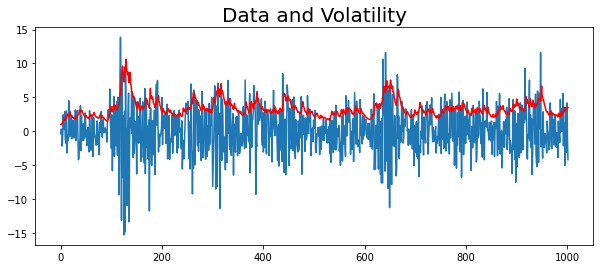

In [57]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.plot(vols, color='red')
plt.title('Data and Volatility', fontsize=20)

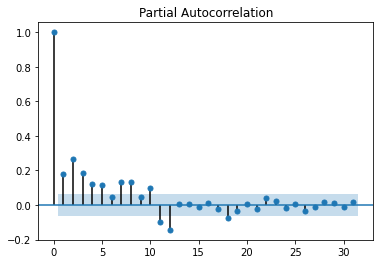

In [58]:

plot_pacf(np.array(series)**2)
plt.show()

In [59]:
train, test = series[:-test_size], series[-test_size:]
model = arch_model(train, p=2, q=2)

In [60]:
model_fit = model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 2287.009912775479
Iteration:      2,   Func. Count:     19,   Neg. LLF: 2285.5720285695015
Iteration:      3,   Func. Count:     29,   Neg. LLF: 2284.817584199849
Iteration:      4,   Func. Count:     39,   Neg. LLF: 2284.721878794696
Iteration:      5,   Func. Count:     49,   Neg. LLF: 2284.232442541533
Iteration:      6,   Func. Count:     58,   Neg. LLF: 2283.884690681818
Iteration:      7,   Func. Count:     67,   Neg. LLF: 2283.811064389757
Iteration:      8,   Func. Count:     76,   Neg. LLF: 2283.6635378591113
Iteration:      9,   Func. Count:     84,   Neg. LLF: 2283.402804344499
Iteration:     10,   Func. Count:     92,   Neg. LLF: 2283.2982369510323
Iteration:     11,   Func. Count:    100,   Neg. LLF: 2283.2908384175253
Iteration:     12,   Func. Count:    109,   Neg. LLF: 2283.2903327694926
Iteration:     13,   Func. Count:    118,   Neg. LLF: 2283.2902038247366
Iteration:     14,   Func. Count:    126,   Neg. LLF: 2283

In [61]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2283.29
Distribution:                  Normal   AIC:                           4578.58
Method:            Maximum Likelihood   BIC:                           4607.41
                                        No. Observations:                  902
Date:                Fri, Apr 16 2021   Df Residuals:                      901
Time:                        16:21:45   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1109  9.368e-02      1.184      0.236 [-7.267e-02,  0.295]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.4361      0.238      1.832  6.697e-02 [-3.049e-02,  0.903]
alpha[1]       0.0595  4.916e-02      1.209      0.226 [-3.689e-02,  0.156]
alpha[2]       0.1099  8.520e-02      1.290      0.197 [-5.705e-02,  0.277]
beta[1]        0.7964      0.539      1.479      0.139    [ -0.259,  1.852]
beta[2]        0.0000      0.447      0.000      1.000    [ -0.877,  0.877]
===========================================================================

Covariance estimator: robust
"""

In [62]:

predictions = model_fit.forecast(horizon=test_size)

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


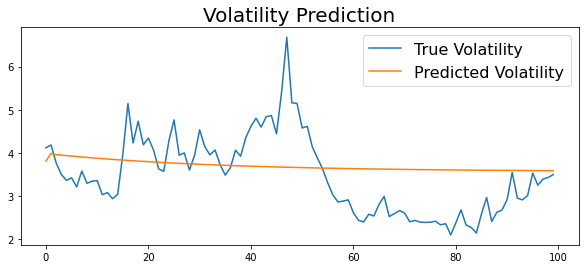

In [63]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]))
plt.title('Volatility Prediction', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


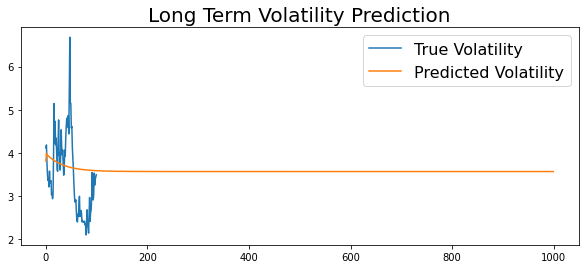

In [64]:
predictions_long_term = model_fit.forecast(horizon=1000)
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(np.sqrt(predictions_long_term.variance.values[-1, :]))
plt.title('Long Term Volatility Prediction', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

***And let's have a little fun and imagine next:***

In [65]:
rolling_predictions = []
for i in range(test_size):
    train = series[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternat

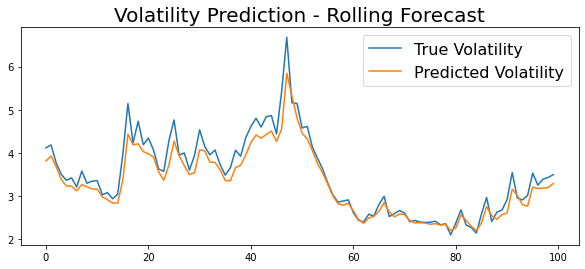

In [66]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

***Look fantastic, but unfortunately not realistic***

# **ARIMA family:**

Since the time series we have chosen is not stationary and has weak seasonality, it makes almost no sense to use it in this form for the autoregression model — the moving average. Let's prepare a row by making it stationary.

In [67]:
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose


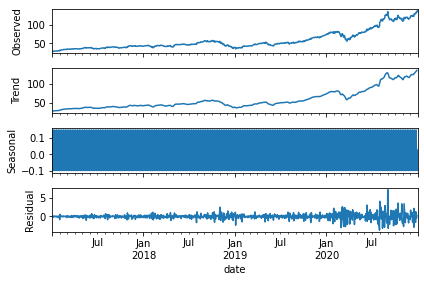

In [68]:
s_dec_add = seasonal_decompose(sdf.price, model="additive")
s_dec_add.plot()
plt.show()

In [69]:
sts.adfuller(sdf.price)

(1.7734193132587437,
 0.9982948156065,
 1,
 1456,
 {'1%': -3.43484922137066,
  '10%': -2.5678279184465946,
  '5%': -2.8635271063560412},
 3931.4090946704705)

In [70]:
sdf_st = sdf.copy()
sdf_st['pr_ret'] = sdf_st.price.pct_change(1).mul(100)
sdf_st = sdf_st.iloc[1:]
sts.adfuller(sdf_st.pr_ret)

(-25.026974996803176,
 0.0,
 1,
 1455,
 {'1%': -3.4348523191002123,
  '10%': -2.567828646449617,
  '5%': -2.8635284734563364},
 4945.484867288823)

In [71]:
sdf_st.isna().sum()

open      0
price     0
low       0
high      0
pr_ret    0
dtype: int64

*Now we will divide the dataset into a training one and what we will test our result on.*

In [72]:
size = int(len(sdf_st)*0.8)
print("Size: ", size)
df_train = sdf_st.iloc[:size]
df_test = sdf_st.iloc[size:]

Size:  1165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


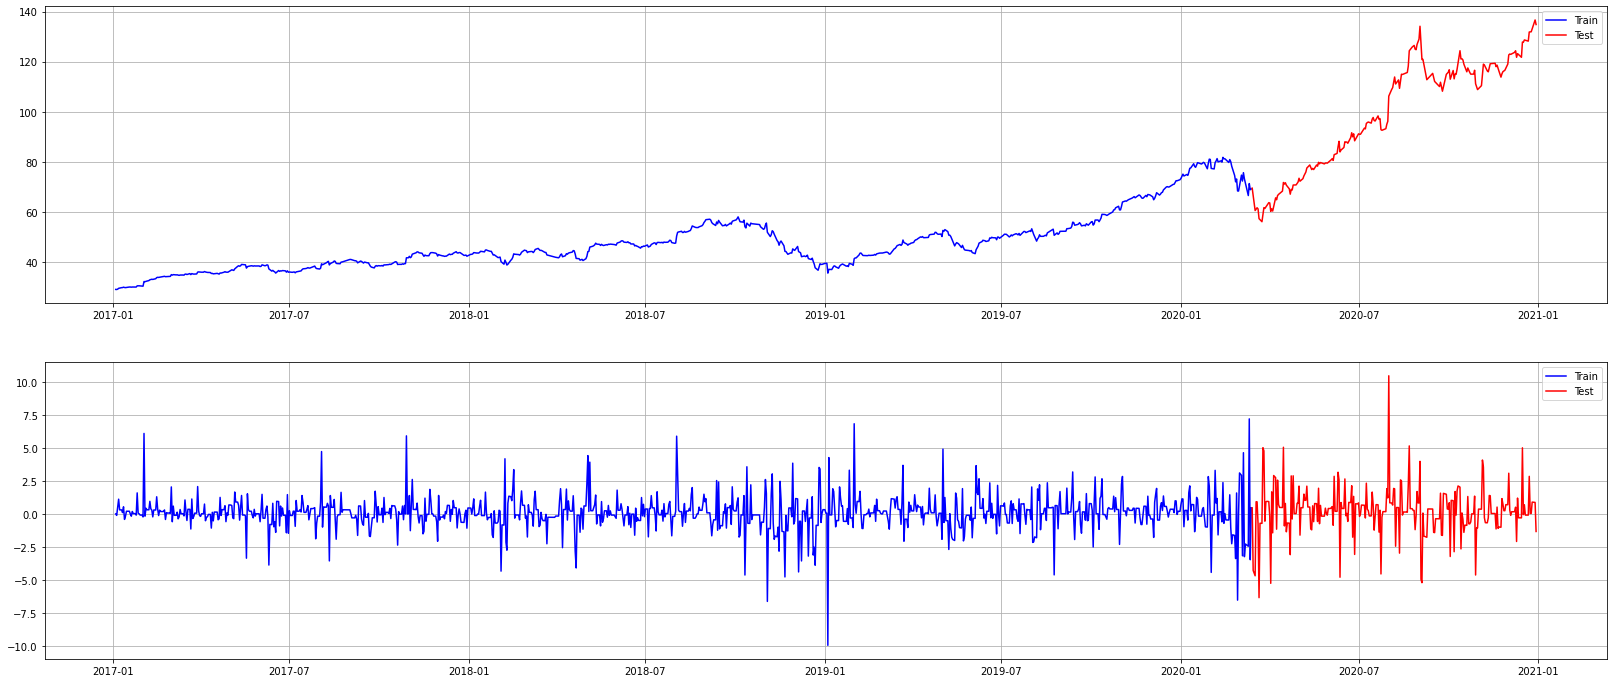

In [73]:
plt.figure(figsize=(28, 12))

plt.subplot(2, 1, 1)
plt.plot(df_train.index, df_train.price, 'blue', label='Train')

plt.subplot(2, 1, 1)
plt.plot(df_test.index, df_test.price, 'r', label='Test')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_train.index, df_train.pr_ret, 'blue', label='Train')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df_test.index, df_test.pr_ret, 'r', label='Test')
plt.legend()
plt.grid(True)

plt.show()

The bottom row is what we need. It can be used to uniquely restore the upper time series, while the lower one is stationary. Let's start predicting:

In [74]:
start_date = "2020-03-14"
end_date = "2020-12-30"

*AR:*

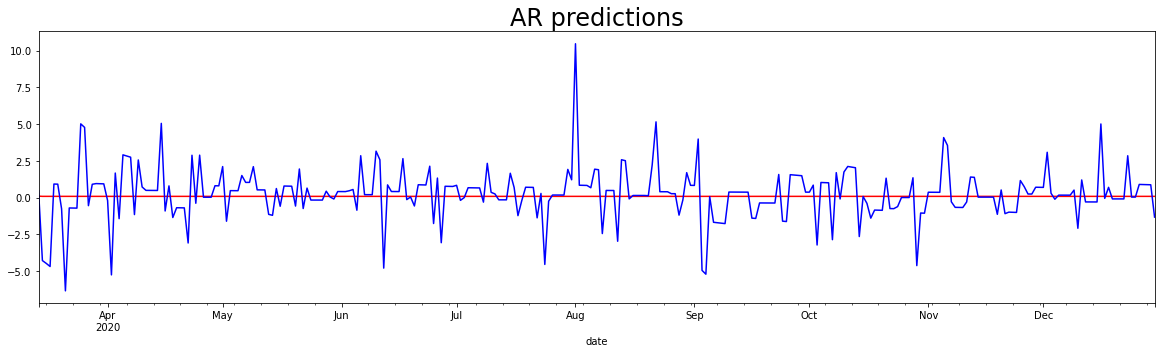

In [75]:
model_ar = ARIMA(df_train.pr_ret, order = (1, 0, 0))
results_ar = model_ar.fit()
df_pred_AR = results_ar.predict(start = start_date, end = end_date)

df_pred_AR[start_date:end_date].plot(figsize = (20, 5), color = "red")
df_test.pr_ret[start_date:end_date].plot(color = "blue")
plt.title("AR predictions", size = 24)
plt.show()


**MA**

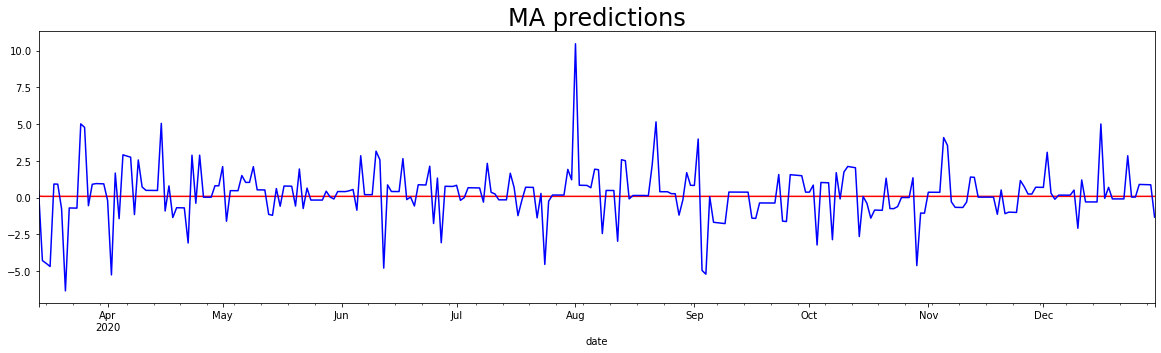

In [76]:
model_ar = ARIMA(df_train.pr_ret, order = (0, 0, 1))
results_ar = model_ar.fit()
df_pred_MA = results_ar.predict(start = start_date, end = end_date)

df_pred_MA[start_date:end_date].plot(figsize = (20, 5), color = "red")
df_test.pr_ret[start_date:end_date].plot(color = "blue")
plt.title("MA predictions", size = 24)
plt.show()

**ARMA**

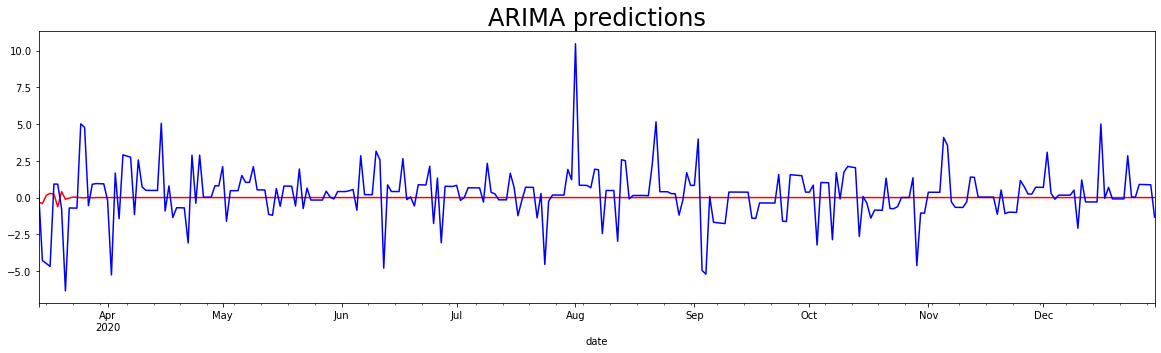

In [77]:
model_ar = ARIMA(df_train.pr_ret, order = (8, 1, 1))
results_ar = model_ar.fit()
df_pred_ARMA = results_ar.predict(start = start_date, end = end_date)

df_pred_ARMA[start_date:end_date].plot(figsize = (20, 5), color = "red")
df_test.pr_ret[start_date:end_date].plot(color = "blue")
plt.title("ARIMA predictions", size = 24)
plt.show()

**SARIMAX**

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


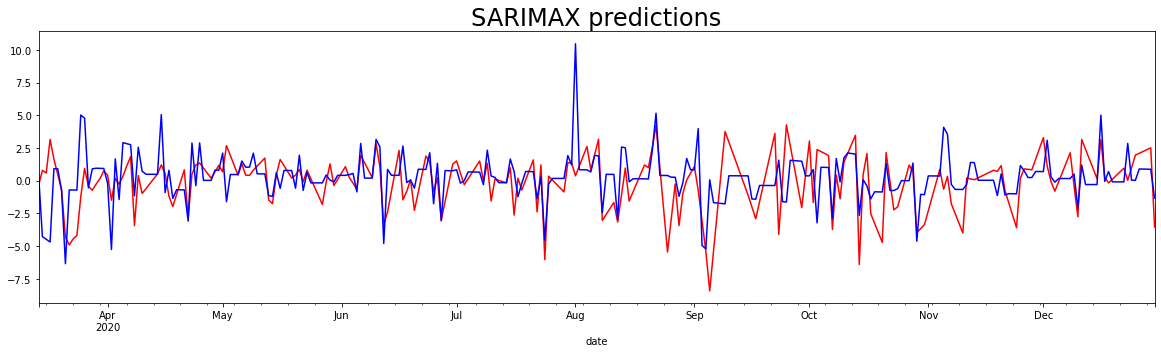

In [78]:
model_ret_sarma = SARIMAX(df_train.pr_ret, exog = df_train[["low", "open", "high"]], order = (3, 0, 4), seasonal_order=(3, 0, 2, 5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date, exog = df_test[["low", "open", "high"]][start_date:end_date])

df_pred_sarma[start_date:end_date].plot(figsize = (20, 5), color = "red")
df_test.pr_ret[start_date:end_date].plot(color = "blue")
plt.title("SARIMAX predictions", size = 24)
plt.show()